# PSF Check

In [1]:
from gammapy.cube import PSFMap
from gammapy.irf import EnergyDependentTablePSF

In [147]:
from pathlib import Path

from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.data import GTI, Observation, EventList
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import EnergyDispersion2D, PSF3D, EnergyDependentMultiGaussPSF, load_cta_irfs

from gammapy.cube import (
    MapDataset,
    MapDatasetEventSampler,
    MapDatasetMaker,
)


In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import astropy.units as u


In [4]:
def get_filename_dataset(livetime):
    filename = f"data/dataset_{livetime.value:.0f}{livetime.unit}.fits.gz"
    return BASE_PATH / filename


def get_filename_events(filename_dataset, filename_model, obs_id):
    obs_id=int(obs_id)
    model_str = filename_model.name.replace(filename_model.suffix, "")
    filename_events = filename_dataset.name.replace("dataset", "events")
    filename_events = BASE_PATH / f"data/models/{model_str}/" / filename_events
    filename_events = filename_events.name.replace(".fits.gz", f"_{obs_id:04d}.fits.gz")
    path = BASE_PATH / f"data/models/{model_str}/" / filename_events
    return path


In [5]:
BASE_PATH = Path("../make.py").parent

In [6]:
model = "point-pwlsimple"
filename_model = BASE_PATH / f"models/{model}.yaml"


In [7]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
POINTING = SkyCoord(0.0, 0.5, frame="galactic", unit="deg")
LIVETIME = 10 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True)
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(4, 4), binsz=0.02, frame="galactic", axes=[ENERGY_AXIS]
)


### Create the dataset

In [32]:
irfs = load_cta_irfs(IRF_FILE)

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
#    maker = MapDatasetMaker(selection=["exposure", "edisp"])
#    maker = MapDatasetMaker(selection=["exposure", "edisp", "background"])
maker = MapDatasetMaker(selection=["exposure"])
dataset = maker.run(empty, observation)


In [33]:
print(dataset.models)

None


In [34]:
a=dataset.npred()

/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


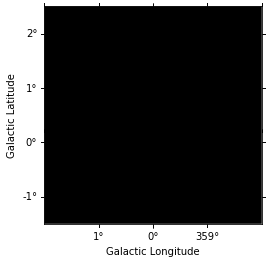

In [35]:
a.plot_interactive()

In [36]:
models = Models.read(filename_model)

In [37]:
print(models)

Models

Component 0: SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 0.000e+00   nan            deg        nan       nan  False
    lat_0 0.000e+00   nan            deg -9.000e+01 9.000e+01  False
    index 2.000e+00   nan                       nan       nan  False
amplitude 1.000e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True

	




In [38]:
dataset.models = models

In [39]:
# print(dataset.npred())

In [40]:
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)


In [41]:
events.table

ENERGY_TRUE,RA_TRUE,DEC_TRUE,TIME,MC_ID,RA,DEC,ENERGY,EVENT_ID
TeV,deg,deg,s,,deg,deg,TeV,
float64,float64,float64,float64,int64,float64,float64,float64,int64
0.4810854600091019,266.3864001019041,-28.937224624952275,10495.205614948645,1,266.3864001019041,-28.937224624952275,0.4810854600091019,0
0.07353832387408077,266.39549386129556,-28.91877821800499,22614.145982195623,1,266.39549386129556,-28.91877821800499,0.07353832387408077,1
2.3042256215233072,266.4002010372554,-28.953632706869026,25716.66746553965,1,266.4002010372554,-28.953632706869026,2.3042256215233072,2
0.47121276266498574,266.3840622149844,-28.93564158259355,9813.168279477395,1,266.3840622149844,-28.93564158259355,0.47121276266498574,3
1.9408190047954321,266.38152775664753,-28.94539147274147,4199.0702567389235,1,266.38152775664753,-28.94539147274147,1.9408190047954321,4
0.2414723853341287,266.413392364421,-28.931775503229478,18370.984217477962,1,266.413392364421,-28.931775503229478,0.2414723853341287,5
0.1634274035969091,266.38624148748943,-28.928162212551868,10187.255415692925,1,266.38624148748943,-28.928162212551868,0.1634274035969091,6
0.9711605822550461,266.3984456128507,-28.910843348961237,11708.105075522326,1,266.3984456128507,-28.910843348961237,0.9711605822550461,7


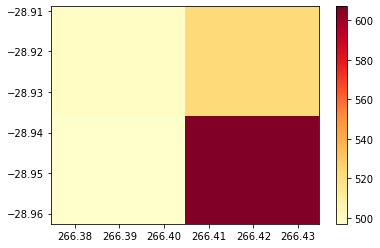

In [103]:
plt.hist2d(events.table['RA_TRUE'],events.table['DEC_TRUE'], bins=2, cmap=plt.cm.YlOrRd)
plt.colorbar()

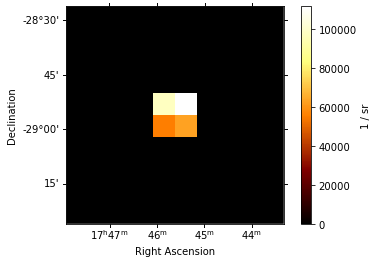

In [72]:
model = PointSpatialModel(lon_0="0.01deg", lat_0="0.01 deg", frame="galactic",)

geom = WcsGeom.create(
    skydir=SkyCoord("0d 0d", frame="galactic"), width=(1, 1), binsz=0.1
)
model.plot(geom=geom, add_cbar=True)


### Compare the PSF

In [155]:
# # psf_mod = PSF3D(0.01*u.TeV, 300*u.TeV, offset=[0, 2, 4, 6, 8] * u.deg, rad_lo=0.5*u.deg, rad_hi=0.5*u.deg, 
#                 psf_value=(0.006/u.deg)**2)

In [156]:
# psf_mod.plot_containment()

In [191]:
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=IRF_FILE, hdu="POINT SPREAD FUNCTION")
# psf_gauss = EnergyDependentMultiGaussPSF(energy_lo=0.01*u.TeV, energy_hi=200*u.TeV, 
#                                          theta=[0, 2, 4, 6, 8] * u.deg, sigmas=[[0.1,0.1,0.1]]*u.deg,
#                                         norms=[1,1,1])
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)

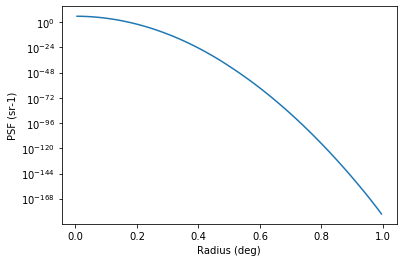

In [192]:
psf_3d.plot_psf_vs_rad()

In [171]:
irfs = load_cta_irfs(IRF_FILE)

irfs['psf'] = psf_3d

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
#    maker = MapDatasetMaker(selection=["exposure", "edisp"])
#    maker = MapDatasetMaker(selection=["exposure", "edisp", "background"])
maker = MapDatasetMaker(selection=["exposure", "psf"])
dataset = maker.run(empty, observation)


In [172]:
dataset.models = models
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)


In [185]:
src_pos = SkyCoord(0*u.deg, 0.0*u.deg, frame='galactic')
evt_pos = SkyCoord(events.table['RA_TRUE'], events.table['DEC_TRUE'], frame='icrs')

In [187]:
sep = src_pos.separation(evt_pos).value

(array([ 34.,  98., 149., 210., 323., 366., 439., 307., 152.,  50.]),
 array([6.83724036e-05, 2.86473120e-03, 5.66108999e-03, 8.45744879e-03,
        1.12538076e-02, 1.40501664e-02, 1.68465252e-02, 1.96428840e-02,
        2.24392428e-02, 2.52356016e-02, 2.80319603e-02]),
 <a list of 10 Patch objects>)

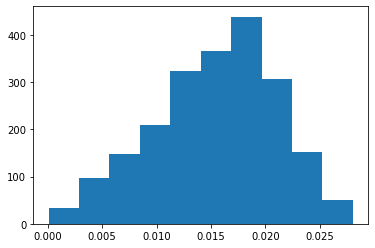

In [188]:
plt.hist(sep)

In [189]:
theta_axis = MapAxis.from_bounds(0, 0.5, nbin=100, unit="deg", name="theta")

psf_value = psf_3d.evaluate(energy=1 * u.TeV, offset=0 * u.deg, rad=theta)
psf_value = psf_value / psf_value.sum()

psf_hist, vals = np.histogram(coords, theta_axis.edges)
plt.step(theta, psf_hist / psf_hist.sum());
plt.plot(theta, psf_value.squeeze())
plt.semilogy()
plt.ylim(1e-6, 1)
plt.xlim(0, 0.2)

NameError: name 'theta' is not defined